In [1]:
# !python --version
# %pip install --upgrade pandas
# %pip install openpyxl
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install plot_keras_history
# %pip install tensorflow
# %pip install keras-tuner
# %pip install -q keras-tcn --no-dependencies

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.python.client import device_lib


print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Historico de datos para realizar la predicción
numData = 729
# Insantes de tiempo futuros a predecir
numPredictions = 20

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). el "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs=1000
# Tamaño del batch
batch = 1024
# Dimensionalidad del espacio de output
units = 16

# Establecer medida de loss
loss="mean_squared_error"
#loss="mean_absolute_percentage_error"

# Establecer learning rate
lr = [0.0, 1e-2, 1e-3, 1e-4]

Setting GPU Memory Growth...
TF version: 2.1.0
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [3]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_30min.xlsx", 
                   header=None, 
                   engine='openpyxl')[0]

# Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
X = pd.DataFrame(np.array(df).reshape(-1, 20))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(21, 41)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(numPredictions)

dfNoNormalized = pd.concat([X, Y], axis=1)

dataToPredict = dfNoNormalized.tail(1)
print("Row for predicting: ", dataToPredict)

# Data Normalization
scaler = MinMaxScaler()
XNormalized = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
YNormalized = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

dfPreproccessed = pd.concat([XNormalized, YNormalized], axis=1)

# Last row is deleted beacuse it is the one for used for the real prediction, 
# it is not useful for the training of the model.
dfPreproccessed.drop(dfNoNormalized.tail(1).index, inplace=True)

print("Preprocessed Dataframe length: ", len(dfPreproccessed))

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

pd.set_option('display.max_columns', dfPreproccessed.shape[1])
print("Head DataFrame Preprocessed\n " + str(dfPreproccessed.head()))
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(XNormalized, 
                                                YNormalized, 
                                                test_size = test_size, 
                                                random_state = 0, 
                                                shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, 
                                              yTrain, 
                                              test_size = val_size, 
                                              random_state = 0,
                                              shuffle=False)

# Show subsets shapes
print("Shapes:")
print("xTrain:\t"+str(xTrain.shape))
print("yTrain:\t"+str(yTrain.shape))
print("xVal:\t"+str(xVal.shape))
print("yVal:\t"+str(yVal.shape))
print("xTest:\t"+str(xTest.shape))
print("yTest:\t"+str(yTest.shape))
print("---------------------------------------------")

Row for predicting:                0           1           2           3           4        5  \
364  323.271333  320.158667  281.495667  465.665167  391.321167  609.922   

              6           7           8           9  ...  col_31  col_32  \
364  776.211667  696.617333  667.006833  663.280667  ...     0.0     0.0   

     col_33  col_34  col_35  col_36  col_37  col_38  col_39  col_40  
364     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[1 rows x 40 columns]
Preprocessed Dataframe length:  364
DataFrame Preproccessed:
        col_1     col_2     col_3     col_4     col_5     col_6     col_7  \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163 

In [4]:

with tf.device('/gpu:0'):
    # Model definition
    model = keras.models.Sequential()
    model.add(GRU(
            units = units ,
            input_shape = (xTrain.shape[1], 1),
        ))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(numPredictions, activation="sigmoid"))

    print("Model Summary: ", model.summary())

    # Model compilation
    model.compile(loss = loss,
                optimizer = "adam",
                metrics = [keras.metrics.MAE, 
                           keras.metrics.MAPE, 
                           keras.metrics.MSE])

    history = model.fit(
        np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
        yTrain,
        epochs=epchs,
        batch_size=batch,
        validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                340       
Total params: 1,252
Trainable params: 1,252
Non-trainable params: 0
_________________________________________________________________
Model Summary:  None
Train on 178 samples, validate on 77 samples
Epoch 1/1000
178/178 [==============================] - 3s 18ms/sample - loss: 0.0628 - mean_absolute_error: 0.2104 - mean_absolute_percentage_error: 425356.3750 - mean_squared_error: 0.0628 - val_loss: 0.0511 - val_mean_absolute_error: 0.1858 - val_mean_absolute_percentage_error: 155.7618 - val_mean_squared_error: 0

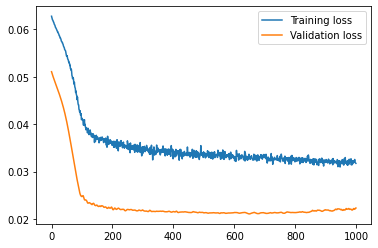

77/77 [==============================] - 0s 513us/sample - loss: 0.0223 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 63.5202 - mean_squared_error: 0.0223
Score: [0.022294782852004102, 0.115569636, 63.52019, 0.022294782]


In [6]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal)
print('Score:', score)